# Collaboration and Competition (ver. 23/03/2021)

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max) from episode {}: {}'.format(i, np.max(scores)))

Score (max) from episode 1: 0.10000000149011612
Score (max) from episode 2: 0.0
Score (max) from episode 3: 0.09000000171363354
Score (max) from episode 4: 0.0
Score (max) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
# Don't close the environment to use it for next experiments
# After close, it is impossible to reload environment on this Unity version.
#env.close()

### 4. Build an MADDGP model.


In [7]:
import time
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')
np.set_printoptions(precision=3, linewidth=120)

In [8]:
torch_device = torch.device('cpu')
print('Device =', torch_device)

Device = cpu


#### Define training model method 

In [9]:
def train(n_episodes = 5000, max_t = 5000, agents = None, filenames = None,
          benchmark_score = 5, rolling_episodes = 10):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int) - maximum number of training episodes
        max_t (int) -  maximum number of timesteps per episode (should be over 1000)
        agents (obj) - training agent instances
        filenames (list) - string of filenames to store weights of actor and critic
        benchmark_score (int) - the score of agent should be over this score
        rolling_episodes (int) - the score is checked whenever number of tries reachs to this
    """
    #start_time = time.time()
    local_time = time.ctime(time.time())    
    print('\nStart training:\t {}'.format(local_time))
            
    all_scores = []                                   
    scores_window = deque(maxlen = rolling_episodes) 
    avg_checked = False
    max_score = -1
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  
        states = env_info.vector_observations              
        scores = np.zeros(len(agents))                     

        for agent in agents:                               
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]  # select actions
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished

            for i, agent in enumerate(agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
            states = next_states                           
            scores += rewards                              
            if np.any(dones):                              
                break

        cur_score = np.max(scores)                         
        scores_window.append(cur_score)                    
        all_scores.append(cur_score)                       
        avg_scores_window = np.mean(scores_window)         

        if cur_score > max_score and cur_score > 2.0:
            max_score = cur_score
            if filenames:
                agent.store_critic_weights(filenames[1] + '.pth')
                
                for i, agent in enumerate(agents):
                    agent.store_actor_weights(filenames[0] + str(i) + '.pth')

        print('\rEpisode {}\tAverage Score: {:.5f}\tScore: {:.5f}'.format(i_episode, avg_scores_window, cur_score), end="")
        
        if i_episode % rolling_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}                '.format(i_episode, avg_scores_window))
        
        if not avg_checked and avg_scores_window >= benchmark_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(
                  i_episode, avg_scores_window))
                  #i_episode - rolling_episodes, avg_scores_window))
            #print('\nTraining time = {:.5f}s'.format(time.time() - start_time))
            local_time = time.ctime(time.time())          
            print('\nTraining end time:\t {}'.format(local_time))

            
            return all_scores
            

    #print('\nTraining time = {:.5f}s'.format(time.time() - start_time))
    local_time = time.ctime(time.time())          
    print('\nTraining end time:\t {}'.format(local_time))

    return all_scores

#### Plot the learning curves for scores vs episodes

In [10]:
import pandas as pd

def plot_scores(scores, benchmark_score, rolling_n_episodes):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(len(scores)), scores, color ='green', label = 'MA DDPG')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('Scores vs. episodes')    
    plt.legend(loc='upper left')
    ax.axhline(benchmark_score, c="red", alpha=0.5)
    
    rolling_window = rolling_n_episodes
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, c='cyan', alpha=0.7)
    
    plt.show()

#### Create replay buffer with hyper-parameters

In [11]:
from agent_ma import ReplayBuffer

memory_parameters = {
    # replay buffer size
    'buffer_size': int(1e6),        
    # minibatch size
    'batch_size': 128,              
    # Seed to generate random numbers
    'seed': 0,                      
}

memory = ReplayBuffer(action_size, memory_parameters['buffer_size'],
                      memory_parameters['batch_size'], memory_parameters['seed'], torch_device)

#### Method for testing my model.

In [12]:
def test(agents, max_t=5000):
    
    env_info = env.reset(train_mode=False)[brain_name] 
    states = env_info.vector_observations        
    scores = np.zeros(len(agents))

    for t_ in range(max_t):
        # select actions
        actions = [agent.act(states[i], add_noise=False) for i, agent in enumerate(agents)]
        env_info = env.step(actions)[brain_name]       
        rewards = env_info.rewards                     
        dones = env_info.local_done                    
        states = env_info.vector_observations          
        scores += rewards                              
        if np.any(dones):                              
            break
    
    print('Score(max): {:.5f}'.format(np.max(scores)))

#### Set hyper-parameters

In [13]:
parameters = {
    # roll over the state to next time step
    'actor_units': [512, 256],    
    # roll over the state to next time step
    'critic_units': [512, 256],         
    # roll over the state to next time step
    'lr_actor': 7e-4,    
    # learning rate of the Critic
    'lr_critic': 3e-3,                  
    
    # discount factor
    'gamma': 0.99,                      
    
    # for soft update of target parameters
    'tau': 0.15, 
    # update parameters per this number
    'update_every': 1,                  
    
    # update parameters per this number
    'seed': 0,  
    # update parameters per this number
    'weight_decay': 0,                  
    
    # Ornstein-Uhlenbeck process
    'noise_theta': 0.15,                
    'noise_sigma': 0.01,                
}

#### Set plot parameters and filenames

In [14]:
rolling_episodes = 100     
benchmark_score = 0.5      

In [15]:
# Filenames of weights of Actor/Critic
actor_file_name = 'weights_actor'
critic_file_name = 'weights_critic'

#### Create agents:

In [16]:
from agent_ma import Agent

agents = [Agent(state_size, action_size, memory, torch_device, parameters)
                 for _ in range(num_agents)]

Agent
       actor_units [512, 256]
       critic_units [512, 256]
       lr_actor 0.0007
       lr_critic 0.003
       gamma 0.99
       tau 0.15
       update_every 1
       seed 0
       weight_decay 0
       noise_theta 0.15
       noise_sigma 0.01
Agent
       actor_units [512, 256]
       critic_units [512, 256]
       lr_actor 0.0007
       lr_critic 0.003
       gamma 0.99
       tau 0.15
       update_every 1
       seed 0
       weight_decay 0
       noise_theta 0.15
       noise_sigma 0.01


### Training

In [17]:
scores = train(5000, 5000, agents, [actor_file_name, critic_file_name],
                      benchmark_score, rolling_episodes)


Start training:	 Mon Apr 19 20:10:14 2021
Episode 100	Average Score: 0.05010                
Episode 195	Average Score: 0.51670	Score: 2.60000
Environment solved in 195 episodes!	Average Score: 0.51670

Training end time:	 Mon Apr 19 20:46:11 2021


### Plot scores

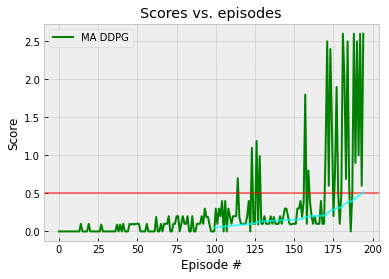

In [18]:
plot_scores(scores, benchmark_score, rolling_episodes)

### Test

In [19]:
agents = [Agent(state_size, action_size, memory, torch_device, parameters)
                 for _ in range(num_agents)]

for i, agent in enumerate(agents):
    agent.load_actor_weights(actor_file_name + str(i) + '.pth')
    agent.load_critic_weights(critic_file_name + '.pth')

test(agents)

Agent
       actor_units [512, 256]
       critic_units [512, 256]
       lr_actor 0.0007
       lr_critic 0.003
       gamma 0.99
       tau 0.15
       update_every 1
       seed 0
       weight_decay 0
       noise_theta 0.15
       noise_sigma 0.01
Agent
       actor_units [512, 256]
       critic_units [512, 256]
       lr_actor 0.0007
       lr_critic 0.003
       gamma 0.99
       tau 0.15
       update_every 1
       seed 0
       weight_decay 0
       noise_theta 0.15
       noise_sigma 0.01
Score(max): 2.60000


#### Close

In [20]:
env.close()

#### Save scores to file

In [21]:
with open('scores.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % score for score in scores)